In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from dask.diagnostics import ProgressBar
plt.style.use('/home/aos/kyan/.config/matplotlib/esm2m.mplstyle')

# Load Data

In [2]:
#land mask data
#ESM2M
land_area_esm2m = xr.open_dataset('../data/processed/GFDL/esm2m.land_area')['land_area']
land_mask_esm2m = land_area_esm2m>0

#CESM2
land_area_cesm2 = xr.open_dataset('../data/processed/CESM2/cesm2.land_area')['__xarray_dataarray_variable__'].isel(ensemble=0)
land_mask_cesm2 = land_area_cesm2>0

In [3]:
# Population data
ds_pop_esm2m = xr.open_dataset('../data/processed/GFDL/population_regrid_esm2m_2.nc')['population']
ds_pop_esm2m = ds_pop_esm2m.where(np.isfinite(ds_pop_esm2m),0)

# Population data
ds_pop_cesm2 = xr.open_dataset('../data/processed/CESM2/population_regrid_cesm2_2.nc')['population']
ds_pop_cesm2 = ds_pop_cesm2.where(np.isfinite(ds_pop_cesm2),0)

In [4]:
# Delta temperature
deltat_esm2m = xr.open_dataarray('../data/processed/GFDL/deltatemp.nc')
deltat_cesm2 = xr.open_dataarray('../data/processed/CESM2/deltatemp.nc')

# Get ToEs: ESM2M

In [5]:
# Future capacity data
ds_esm2m = xr.open_dataarray('../data/processed/GFDL/esm2m_future_hottestmonths.nc')
# Baseline capacity data
ds_base_esm2m = xr.open_dataarray('../data/processed/GFDL/esm2m_baseline_hottestmonths.nc')

In [6]:
# Labor reduction thresholds used to define ToE
labor_thres = [0.75,0.5,0.25]

# Calculate ToEs for all grid cells and ensemble members
ds_toe_esm2m = lf.toe_summer(ds_esm2m,ds_base_esm2m,labor_thres).compute()

In [7]:
ds_toe_esm2m = ds_toe_esm2m.where(land_mask_esm2m,np.nan)

# Get ToEs: CESM2

In [8]:
# Future capacity data
ds_cesm2 = xr.open_dataarray('../data/processed/CESM2/cesm2_future_hottestmonths.nc')
# Baseline capacity data
ds_base_cesm2 = xr.open_dataarray('../data/processed/CESM2/cesm2_baseline_hottestmonths.nc')

In [9]:
# Labor reduction thresholds used to define ToE
labor_thres = [0.75,0.5,0.25]

# Calculate ToEs for all grid cells and ensemble members
ds_toe_cesm2 = lf.toe_summer(ds_cesm2,ds_base_cesm2,labor_thres).compute()

In [10]:
ds_toe_cesm2 = ds_toe_cesm2.where(land_mask_cesm2,np.nan)

# Spatial Maps

/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


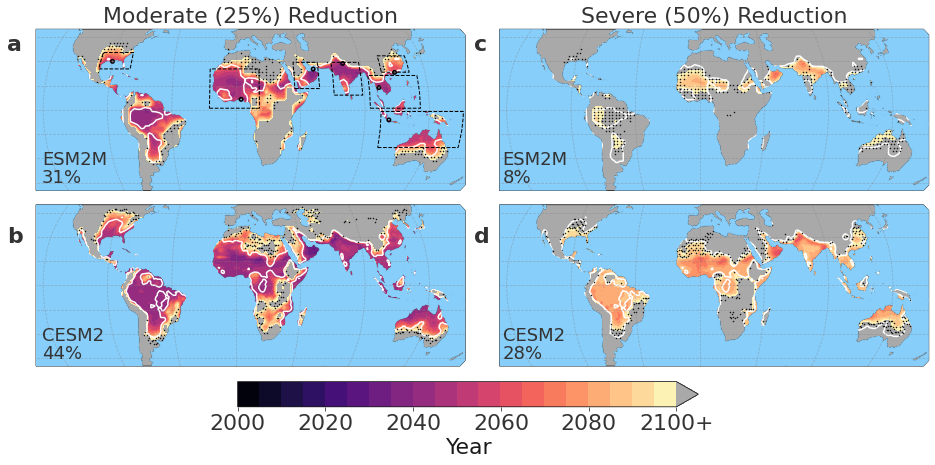

In [107]:
lf.spatial_toe(ds_toe_esm2m,ds_toe_cesm2,ds_base_esm2m,ds_base_cesm2,'Ensemble Mean Time of Emergence for Labor Capacity Reduction',['0.75','0.5'])

# Range Plot

In [ ]:
lf.range_plot(ds_toe_esm2m,ds_toe_cesm2,'Ensemble Range of First-Occurrence',['0.75','0.5'])

# Temperature of Emergence

In [11]:
ds_frac_esm2m = lf.frac_emerge(ds_toe_esm2m,ds_pop_esm2m)/ds_pop_esm2m.sum(['lat','lon'])
ds_frac_esm2m = ds_frac_esm2m.assign_coords({'temp':deltat_esm2m.sel(year=ds_frac_esm2m['year'])}).drop('year')

In [12]:
ds_frac_cesm2 = lf.frac_emerge(ds_toe_cesm2,ds_pop_cesm2)/ds_pop_cesm2.sum(['lat','lon'])
ds_frac_cesm2 = ds_frac_cesm2.assign_coords({'temp':deltat_cesm2.sel(year=ds_frac_cesm2['year'])}).drop('year')

In [58]:
def temp_emerge_plot(ds_toe_esm2m,ds_toe_cesm2,ds_pop_esm2m,ds_pop_cesm2,title,ax,sublabel,ylabel=False,xlabel=False,mark_year=False):
    '''Plot a single time series of fraction of population emerged'''
    
    thres = ['0.75','0.5','0.25']
    
    # Calculate fraction of population that has emerged
    ds_frac_esm2m = lf.frac_emerge(ds_toe_esm2m,ds_pop_esm2m)/ds_pop_esm2m.sum(['lat','lon'])
    ds_frac_esm2m = ds_frac_esm2m.assign_coords({'temp':deltat_esm2m.sel(year=ds_frac_esm2m['year'])}).drop('year')
    
    ds_frac_cesm2 = lf.frac_emerge(ds_toe_cesm2,ds_pop_cesm2)/ds_pop_cesm2.sum(['lat','lon'])
    ds_frac_cesm2 = ds_frac_cesm2.assign_coords({'temp':deltat_cesm2.sel(year=ds_frac_cesm2['year'])}).drop('year')

    # Thresholds for ESM2M
    ax.scatter(ds_frac_esm2m['temp'],ds_frac_esm2m[thres[0]].mean('ensemble'),color='cornflowerblue',s=25,marker='o')
    ax.scatter(ds_frac_esm2m['temp'],ds_frac_esm2m[thres[1]].mean('ensemble'),color='mediumblue',s=25,marker='o')
    ax.scatter(ds_frac_esm2m['temp'],ds_frac_esm2m[thres[2]].mean('ensemble'),color='darkblue',s=25,marker='v')
    for ens in ds_frac_esm2m['ensemble']:
        ax.scatter(ds_frac_esm2m['temp'],ds_frac_esm2m[thres[0]].sel(ensemble=ens),color='cornflowerblue',s=3,marker='o',alpha=0.1)
        ax.scatter(ds_frac_esm2m['temp'],ds_frac_esm2m[thres[1]].sel(ensemble=ens),color='mediumblue',s=3,marker='o',alpha=0.1)
        ax.scatter(ds_frac_esm2m['temp'],ds_frac_esm2m[thres[2]].sel(ensemble=ens),color='darkblue',s=3,marker='v',alpha=0.1)

    # Thresholds for CESM2
    ax.scatter(ds_frac_cesm2['temp'],ds_frac_cesm2[thres[0]].mean('ensemble'),color='lightcoral',s=25,marker='o')
    ax.scatter(ds_frac_cesm2['temp'],ds_frac_cesm2[thres[1]].mean('ensemble'),color='tab:red',s=25,marker='o')
    ax.scatter(ds_frac_cesm2['temp'],ds_frac_cesm2[thres[2]].mean('ensemble'),color='darkred',s=25,marker='v')
    for ens in ds_frac_cesm2['ensemble']:
        ax.scatter(ds_frac_cesm2['temp'],ds_frac_cesm2[thres[0]].sel(ensemble=ens),color='lightcoral',s=3,marker='o',alpha=0.1)
        ax.scatter(ds_frac_cesm2['temp'],ds_frac_cesm2[thres[1]].sel(ensemble=ens),color='tab:red',s=3,marker='o',alpha=0.1)
        ax.scatter(ds_frac_cesm2['temp'],ds_frac_cesm2[thres[2]].sel(ensemble=ens),color='darkred',s=3,marker='v',alpha=0.1)
        
    if mark_year:
        x1 = deltat_esm2m.sel(year=2050)
        y1 = ds_frac_esm2m.mean('ensemble').isel(year=51)[thres[0]]
        ax.plot(x1,y1,markersize=18,marker='o',markerfacecolor='None',markeredgecolor='dimgray',markeredgewidth=2)
        ax.annotate('2050',[x1,y1],xytext=(-80,0),textcoords='offset points',fontsize=22,color='cornflowerblue',fontweight='bold')
        
        x2 = deltat_cesm2.sel(year=2050)
        y2 = ds_frac_cesm2.mean('ensemble').isel(year=51)[thres[0]]
        ax.plot(x2,y2,markersize=18,marker='o',markerfacecolor='None',markeredgecolor='dimgray',markeredgewidth=2)
        ax.annotate('2050',[x2,y2],xytext=(-80,0),textcoords='offset points',fontsize=22,color='lightcoral',fontweight='bold')
    
    # Set labels, limits, title
    if xlabel:
        ax.set_xlabel(u'Δ Temperature ($^\circ$C)',fontsize=24,fontweight='bold')
    else:
        ax.set_xlabel(None)
    if ylabel:
        ax.set_ylabel('Fraction of Population',fontsize=24,fontweight='bold')
    else:
        ax.set_ylabel(None)
    ax.set_ylim([0,1])
    ax.set_title(title,fontsize=26,fontweight='bold')
    ax.text(-0.5,1,sublabel,fontweight='bold',fontsize=26)
    ax.set_xticks([1,1.5,2,3,4])
    ax.set_xticklabels(['1.0','1.5','2.0','3.0','4.0'],rotation=25)
    ax.get_xticklabels()[1].set_color('red')
    ax.get_xticklabels()[1].set_weight('bold')

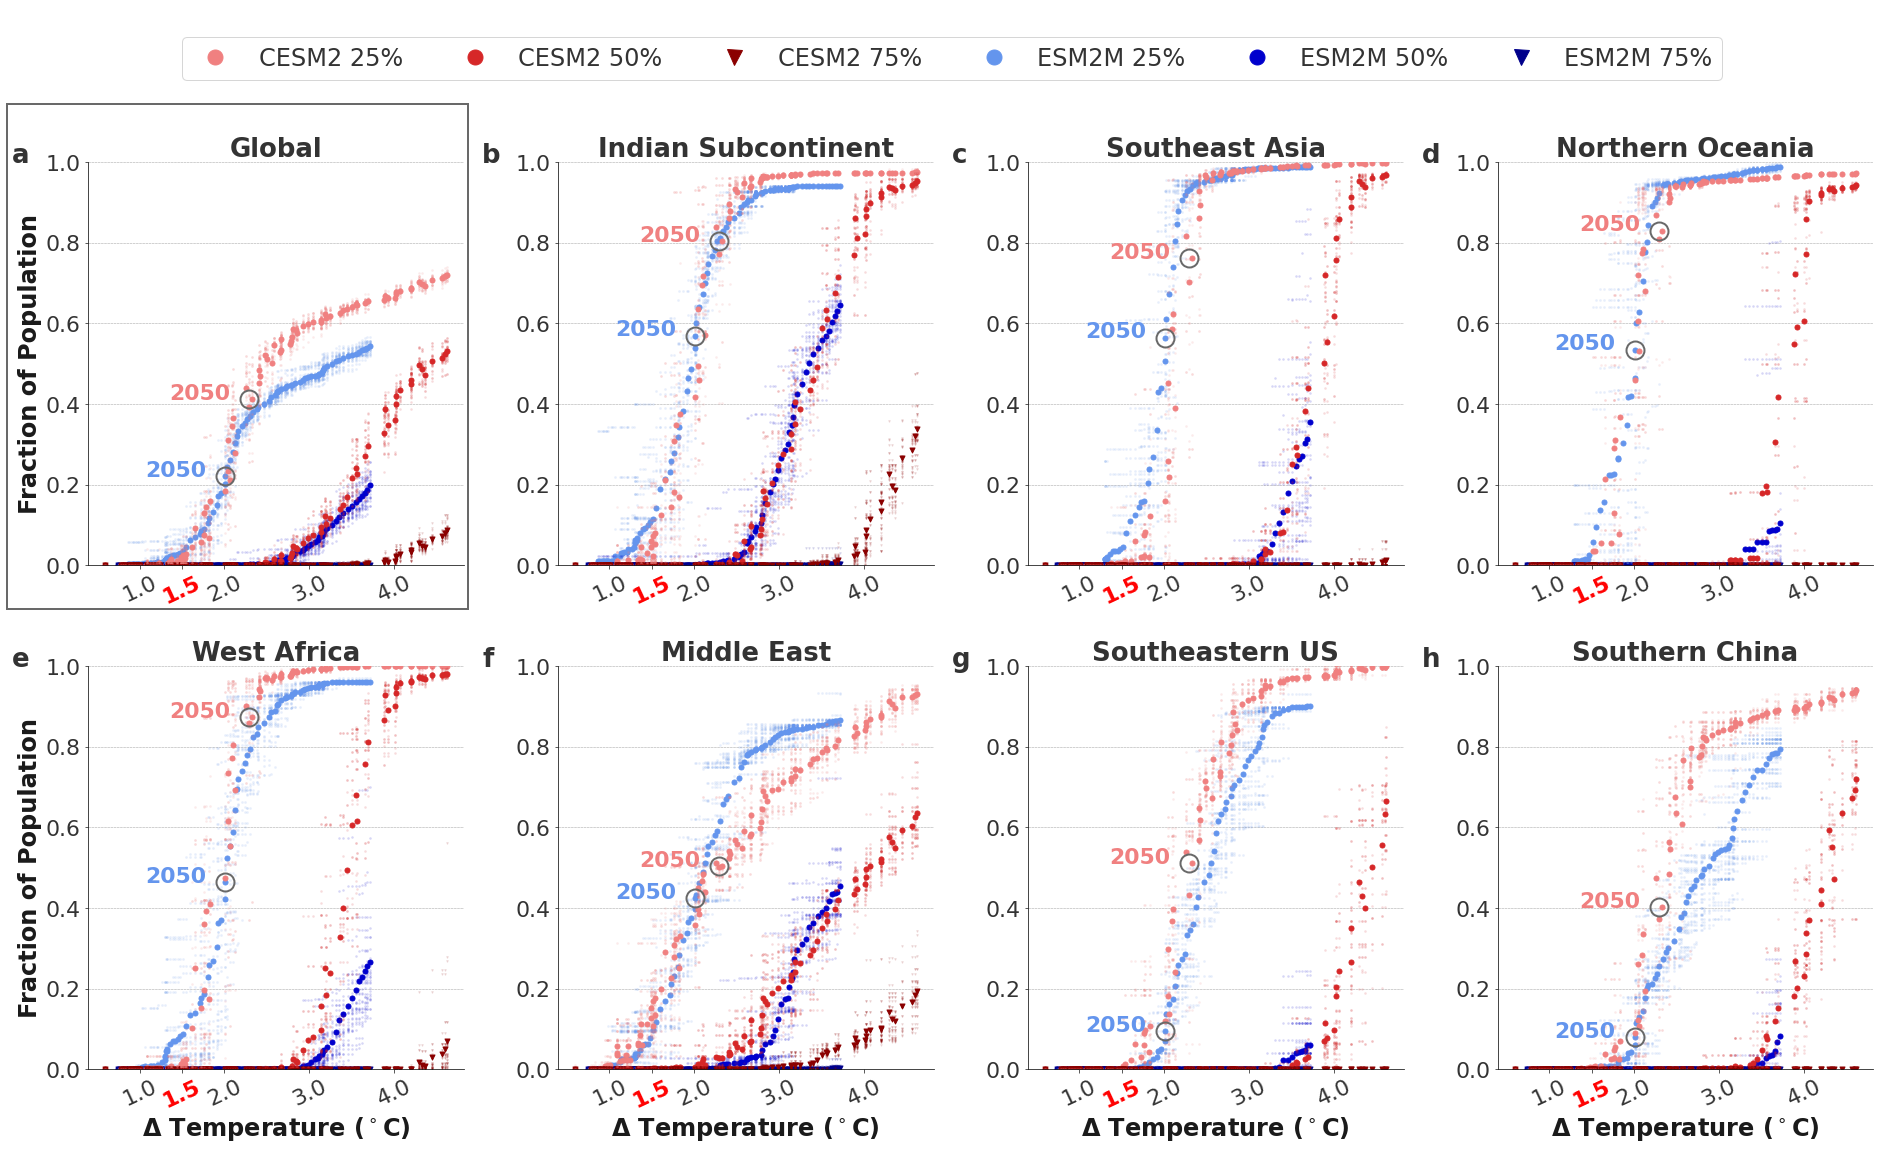

In [59]:
# Regions to plot
regions = ['Global','Indian Subcontinent','Southeast Asia','Northern Oceania','West Africa','Middle East','Southeastern US','Southern China']
sublabels = ['a','b','c','d','e','f','g','h']

# Create figure and axes
fig, axs = plt.subplots(figsize=(32,18),nrows=2,ncols=4)

# Running counter to determine axis
index = 0

# Loop through regions
for region in regions:
    # Get correct axis
    ax = axs[int(index/4)][index%4]
    
    # Get ToE and population data for region
    toe_esm2m = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    pop_esm2m = lf.slice_region(ds_pop_esm2m,region,'GFDL')
    toe_cesm2 = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    pop_cesm2 = lf.slice_region(ds_pop_cesm2,region,'CESM2')
    
    # Call function to plot for this region
    xlabel = False
    ylabel = False
    sublabel = sublabels[index]
    if index>3:
        xlabel = True
    if (index%4)== 0:
        ylabel = True
    temp_emerge_plot(toe_esm2m,toe_cesm2,pop_esm2m,pop_cesm2,region,ax,sublabel,ylabel,xlabel,mark_year=True)
    index+=1
    
rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.09, 0.48), 0.2, 0.39, fill=False, color='dimgray', lw=2, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

# Set legend
light_blue = mlines.Line2D([], [], color='cornflowerblue', marker='o', markersize=10, linestyle='None', label='ESM2M 25%')
dark_blue = mlines.Line2D([], [], color='mediumblue', marker='o', markersize=10, linestyle='None', label='ESM2M 50%')
darkest_blue = mlines.Line2D([], [], color='darkblue', marker='v', markersize=10, linestyle='None', label='ESM2M 75%')

light_red = mlines.Line2D([], [], color='lightcoral', marker='o', markersize=10, linestyle='None', label='CESM2 25%')
dark_red = mlines.Line2D([], [], color='tab:red', marker='o', markersize=10, linestyle='None', label='CESM2 50%')
darkest_red = mlines.Line2D([], [], color='darkred', marker='v', markersize=10, linestyle='None', label='CESM2 75%')

# Create axis at top for legend
fig.subplots_adjust(top=0.825)
legend_ax = fig.add_axes([0.3, 0.865, 0.4, 0.08])
legend_ax.legend(handles=[light_red,dark_red,darkest_red,light_blue,dark_blue,darkest_blue],ncol=6,loc='center',fontsize=24,markerscale=1.5);

# Make legend axis markings invisible 
legend_ax.set_frame_on(False)
legend_ax.grid(False)
legend_ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)    
    
# Make sure plots don't overlap
fig.subplots_adjust(wspace=.25,hspace=.25)
#fig.suptitle('Fraction of Population Having Experienced Reduced Labor Capacity',fontsize=32,fontweight='bold');

In [104]:
# percent of population affected by 75% reduction at end of century, CESM2
ds_frac_cesm2['0.25'].isel(year=100).mean()

<xarray.DataArray '0.25' ()>
array(0.08729373)
Coordinates:
    raster   int32 5
    temp     float32 4.6185303

# Event Plot

In [63]:
regions = ['Southern China','Southeastern US','Middle East','West Africa','Northern Oceania','Southeast Asia','Indian Subcontinent']
cities=['Guangzhou','New Orleans','Dubai','Lagos','Jakarta','Bangkok','Delhi']
thres = ['0.75','0.5']

esm2m_1 = xr.Dataset()
esm2m_2 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    ds_region = ds_region.where(ds_region<2101,np.nan)
    esm2m_1[region] = ds_region[thres[0]].weighted(ds_pop_esm2m).mean(['lat','lon'],skipna=True)
    esm2m_2[region] = ds_region[thres[1]].weighted(ds_pop_esm2m).mean(['lat','lon'],skipna=True)

esm2m_1 = esm2m_1.to_array(dim='region')
esm2m_2 = esm2m_2.to_array(dim='region')

ds_global = ds_toe_esm2m.where(ds_toe_esm2m<2101,np.nan)
esm2m_global_1 = ds_global[thres[0]].weighted(ds_pop_esm2m).mean(['lat','lon'],skipna=True)
esm2m_global_2 = ds_global[thres[1]].weighted(ds_pop_esm2m).mean(['lat','lon'],skipna=True)

esm2m_city_1 = xr.Dataset()
esm2m_city_2 = xr.Dataset()

for city in cities:
    ds_city = lf.slice_city(ds_toe_esm2m,city,'GFDL')
    esm2m_city_1[city] = ds_city[thres[0]].weighted(ds_pop_esm2m).mean(['lat','lon'],skipna=True)
    esm2m_city_2[city] = ds_city[thres[1]].weighted(ds_pop_esm2m).mean(['lat','lon'],skipna=True)

esm2m_city_1 = esm2m_city_1.to_array(dim='city')
esm2m_city_2 = esm2m_city_2.to_array(dim='city')

In [64]:
cesm2_1 = xr.Dataset()
cesm2_2 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    ds_region = ds_region.where(ds_region<2101,np.nan)
    cesm2_1[region] = ds_region[thres[0]].weighted(ds_pop_cesm2).mean(['lat','lon'],skipna=True)
    cesm2_2[region] = ds_region[thres[1]].weighted(ds_pop_cesm2).mean(['lat','lon'],skipna=True)
    
cesm2_1 = cesm2_1.to_array(dim='region')
cesm2_2 = cesm2_2.to_array(dim='region')

ds_global = ds_toe_cesm2.where(ds_toe_cesm2<2101,np.nan)
cesm2_global_1 = ds_global[thres[0]].weighted(ds_pop_cesm2).mean(['lat','lon'],skipna=True)
cesm2_global_2 = ds_global[thres[1]].weighted(ds_pop_cesm2).mean(['lat','lon'],skipna=True)

cesm2_city_1 = xr.Dataset()
cesm2_city_2 = xr.Dataset()

for city in cities:
    ds_city = lf.slice_city(ds_toe_cesm2,city,'CESM2')
    cesm2_city_1[city] = ds_city[thres[0]].weighted(ds_pop_cesm2).mean(['lat','lon'],skipna=True)
    cesm2_city_2[city] = ds_city[thres[1]].weighted(ds_pop_cesm2).mean(['lat','lon'],skipna=True)

cesm2_city_1 = cesm2_city_1.to_array(dim='city')
cesm2_city_2 = cesm2_city_2.to_array(dim='city')

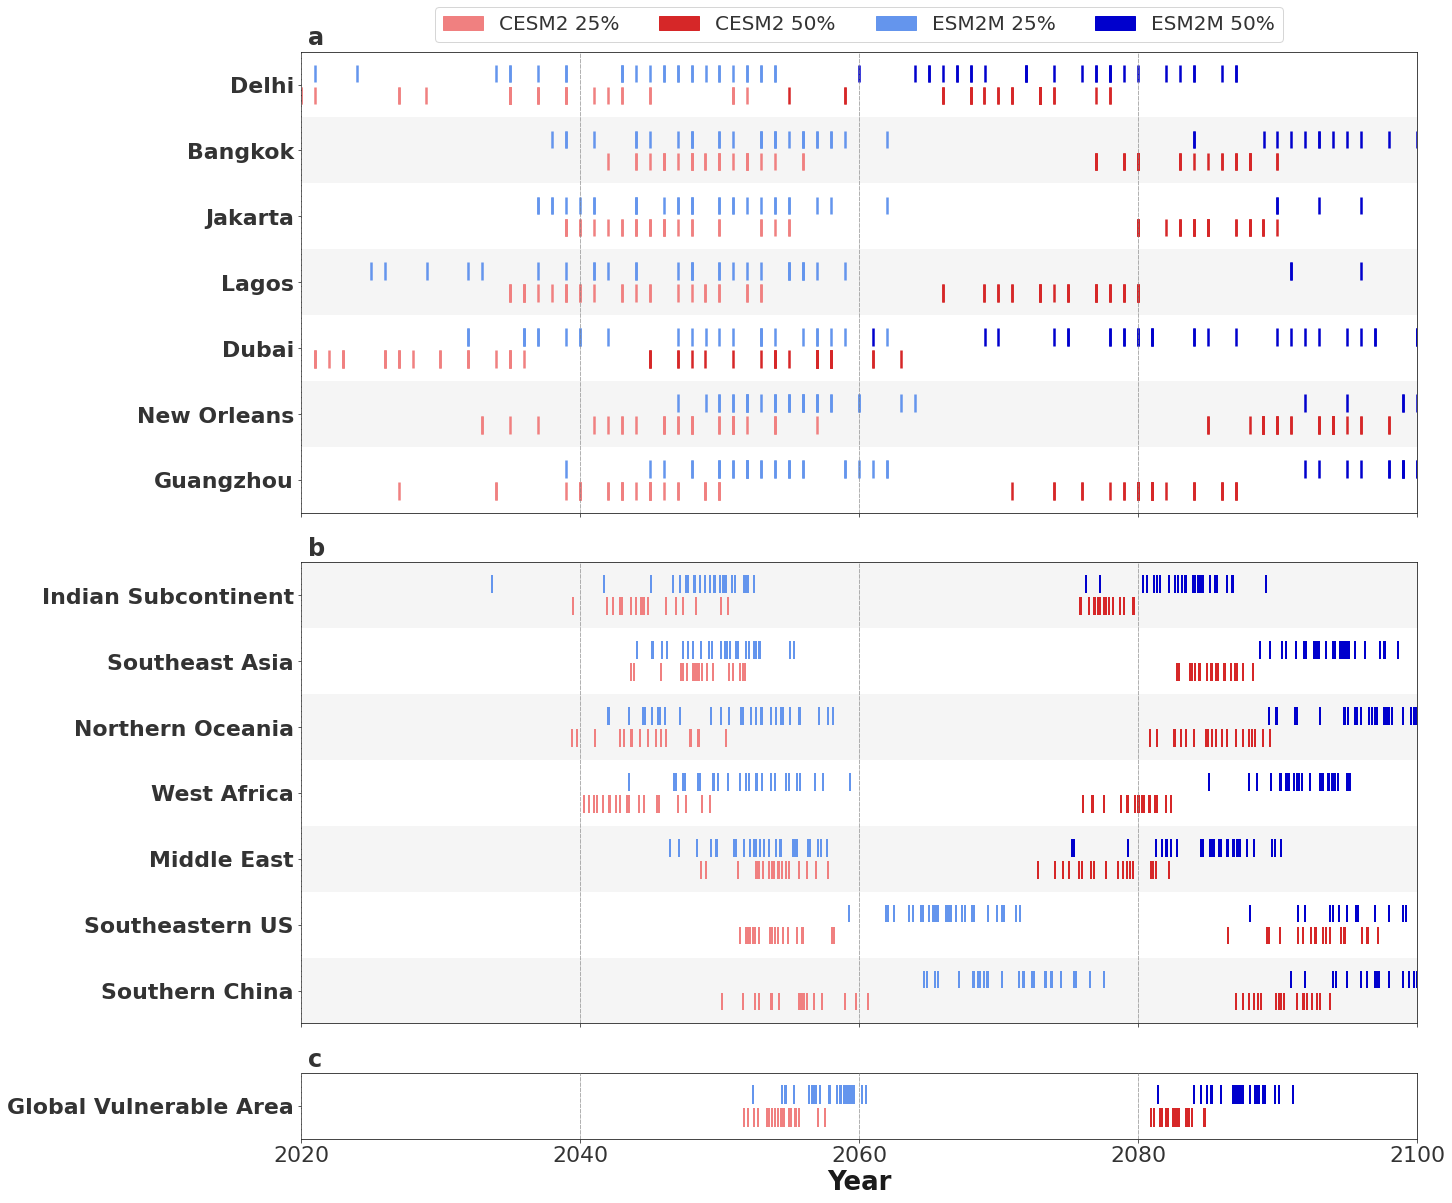

In [95]:
fig,axs=plt.subplots(nrows=3,figsize=(20,20),gridspec_kw={'height_ratios': [7,7,1]})

axs[1].eventplot(cesm2_1,orientation='horizontal',colors='lightcoral',linelengths=0.8,linewidths=2,lineoffsets=[1,4,7,10,13,16,19]);
axs[1].eventplot(cesm2_2,orientation='horizontal',colors='tab:red',linelengths=0.8,linewidths=2,lineoffsets=[1,4,7,10,13,16,19]);

axs[1].eventplot(esm2m_1,orientation='horizontal',colors='cornflowerblue',linelengths=0.8,linewidths=2,lineoffsets=[2,5,8,11,14,17,20]);
axs[1].eventplot(esm2m_2,orientation='horizontal',colors='mediumblue',linelengths=0.8,linewidths=2,lineoffsets=[2,5,8,11,14,17,20]);

locs = np.arange(1.5,25.5,3)
axs[1].set_yticks(locs)
axs[1].set_yticklabels(regions,fontweight='bold');
axs[1].set_xlim([2020,2100]);
axs[1].set_ylim([0,21])
axs[1].set_xticks(range(2020,2120,20))
axs[1].set_xticklabels([])
axs[1].set_axisbelow(False)
axs[1].grid(False)
axs[1].grid(True,linewidth=1,axis='x')
axs[1].set_facecolor('white')
axs[1].spines['top'].set_visible(True)
axs[1].spines['right'].set_visible(True)

# Alternating background color
for i in range(0,24,6):
    axs[1].axhspan(i, i+3, facecolor='whitesmoke')

axs[2].eventplot(cesm2_global_1,orientation='horizontal',colors='lightcoral',linelengths=0.8,linewidths=2,lineoffsets=[1]);
axs[2].eventplot(cesm2_global_2,orientation='horizontal',colors='tab:red',linelengths=0.8,linewidths=2,lineoffsets=[1]);

axs[2].eventplot(esm2m_global_1,orientation='horizontal',colors='cornflowerblue',linelengths=0.8,linewidths=2,lineoffsets=[2]);
axs[2].eventplot(esm2m_global_2,orientation='horizontal',colors='mediumblue',linelengths=0.8,linewidths=2,lineoffsets=[2]);

axs[2].set_yticks([1.5])
axs[2].set_yticklabels(['Global Vulnerable Area'],fontweight='bold');
axs[2].set_xlim([2020,2100]);
axs[2].set_xticks(range(2020,2120,20))
axs[2].set_xticklabels(range(2020,2120,20))
axs[2].set_xlabel('Year',fontsize=26,fontweight='bold')
axs[2].set_axisbelow(False)
axs[2].grid(False)
axs[2].grid(True,linewidth=1,axis='x')
axs[2].set_facecolor('white')
axs[2].spines['top'].set_visible(True)
axs[2].spines['right'].set_visible(True)

axs[0].eventplot(cesm2_city_1,orientation='horizontal',colors='lightcoral',linelengths=0.8,linewidths=2.5,lineoffsets=[1,4,7,10,13,16,19]);
axs[0].eventplot(cesm2_city_2,orientation='horizontal',colors='tab:red',linelengths=0.8,linewidths=2.5,lineoffsets=[1,4,7,10,13,16,19]);

axs[0].eventplot(esm2m_city_1,orientation='horizontal',colors='cornflowerblue',linelengths=0.8,linewidths=2.5,lineoffsets=[2,5,8,11,14,17,20]);
axs[0].eventplot(esm2m_city_2,orientation='horizontal',colors='mediumblue',linelengths=0.8,linewidths=2.5,lineoffsets=[2,5,8,11,14,17,20]);

locs = np.arange(1.5,22.5,3)
axs[0].set_ylim([0,21])
axs[0].set_yticks(locs)
axs[0].set_yticklabels(cities,fontweight='bold');
axs[0].set_xlim([2020,2100]);
axs[0].set_xticks(range(2020,2120,20))
axs[0].set_xticklabels([])
axs[0].set_axisbelow(False)
axs[0].grid(False)
axs[0].grid(True,linewidth=1,axis='x')
axs[0].set_facecolor('white')
axs[0].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)

# Alternating background color
for i in range(3,21,6):
    axs[0].axhspan(i, i+3, facecolor='whitesmoke')

# Set legend
light_blue_patch = mpatches.Patch(color='cornflowerblue', label='ESM2M 25%')
dark_blue_patch = mpatches.Patch(color='mediumblue', label='ESM2M 50%')
light_red_patch = mpatches.Patch(color='lightcoral', label='CESM2 25%')
dark_red_patch = mpatches.Patch(color='tab:red', label='CESM2 50%')

axs[0].legend(handles=[light_red_patch,dark_red_patch,light_blue_patch,dark_blue_patch],ncol=5,fancybox=True,loc='lower center',bbox_to_anchor=(0.5,1));
fig.subplots_adjust(hspace=.15)
#axs[0].set_title('Regional Population-Weighted Average Time of Emergence: Ensemble Spread\n\n',fontsize=28,fontweight='bold');

plt.figtext(0.13,0.885,'a',fontweight='bold',fontsize=24)
plt.figtext(0.13,0.53,'b',fontweight='bold',fontsize=24)
plt.figtext(0.13,0.175,'c',fontweight='bold',fontsize=24);
#plt.savefig('barcode_toe.png',dpi=300)